### This is using FastAI v1 codebase

In [1]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

PATH = "data/"

### Begin reading in and prepping data

In [3]:
df = pd.read_csv(f'{PATH}training_data.csv')
df.shape

(25000, 3)

In [4]:
df_tst = pd.read_csv(f'{PATH}holdout_for_test.csv')
df_tst.shape

(500, 3)

### Save a list of unique labels from both Train/Valid and Test datasets

In [5]:
# keep a list of unique lables that we can use later when testing
labels = df['label_id'].unique()
labels.sort()

# Do the same for the Test (holdout) data
labels_tst = df_tst['label_id'].unique()
labels_tst.sort()

labels.shape, labels_tst.shape

((5381,), (257,))

### See if any Test labels are unique to Train/Valid labels

In [6]:
s = set(labels)
t = set(labels_tst)
if t.issubset(s) == False:
    labels_tst_unique = sorted(t.difference(s))
print("There are " + str(len(labels_tst_unique)) + " unique labels in Test that are NOT found in Train/Valid")

There are 1 unique labels in Test that are NOT found in Train/Valid


### Split into Train and Validation DataFrames

In [7]:
# Keep ONLY records that have AT LEAST TWO OR MORE of the SAME Label.
df2 = df[df.duplicated(subset=['label_id'], keep=False)]

# Check to make sure (id column should be False)
df2[df2.groupby(['label_id']).count()<2].any()

brand_id    False
text        False
id          False
dtype: bool

In [8]:
df_trn, df_val = train_test_split(df2, random_state=42, stratify = df2['label_id'], test_size = 0.3)
df_trn.shape, df_val.shape

((15722, 3), (6738, 3))

## Begin Language Model Learning
### Create a Language Model DataBunch from our train/validation DataFrames
#### Note: since we are only fine-tuning our language model, and NOT classification (yet), we don't need to worry about labels right now.

In [11]:
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = PATH)

### Save the LM DataBunch so that we don't need to run the above each and everytime

In [12]:
# Un-comment below if an LM DataBunch does not exist in file system 
data_lm.save('LM_sample.pkl')

### Otherwise, load the LM DataBunch from the filesystem and create the LM Learner with it.
#### This is the minimum required to create the LM Learner, which will be used to hold the pre-trained model and any subsequent fine-tuning

In [13]:
data_lm = load_data(PATH, 'LM_sample.pkl')

### Use the AWD_LSTM RNN Architecture with our domain LM.   This will enhance the model's ability to predict the "next word" in the sentence (it is NOT used for Classification)

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=PATH, wd=0.1).to_fp16()

In [15]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.019099,3.661697,0.347535,38.927345,02:23


In [16]:
learn.save('LM_one_epoch')

In [17]:
learn = learn.load('LM_one_epoch')

### Now save the Language Model's "encoder" for the One Epoch training run just completed.
#### We only need to save the model's "encoder", which is the part that is responsible for creating and updating the hidden state.
#### Note:  Again, this model is only concerned with predicting the "next word" in a sentence (hence, the term "Language Model").  We will not care about this any further.  The next section will start to focus on the Classification learning.

In [18]:
learn.save_encoder('LM_finetuned')

In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.640742,3.429807,0.383648,30.870667,02:53
1,3.389696,3.197397,0.421910,24.468771,02:54
2,3.216144,3.036037,0.448242,20.822578,02:54
3,3.061459,2.918934,0.467349,18.521526,02:54
4,2.911416,2.837747,0.481658,17.077246,02:55
5,2.763374,2.777495,0.491924,16.078688,02:55
6,2.713137,2.733564,0.499942,15.387641,02:55
7,2.580729,2.705786,0.504858,14.966064,02:55
8,2.556458,2.693688,0.507203,14.786101,02:55
9,2.496719,2.691999,0.507705,14.761170,02:55


### These look like good results for a Language Model (ie: it will select the next word in a sentence correctly 50% of the time), so save this iteration of Language Model (LM) Training for future experimenting

In [20]:
learn.save('LM_ten_epochs')

In [21]:
learn = learn.load('LM_ten_epochs')

### We should also save the model's "encoder", which is the part that is responsible for creating and updating the hidden state.
#### Note:  Again, this model is only concerned with predicting the "next word" in a sentence (hence, the term "Language Model").  We will not care about this any further.  The next section will start to focus on the Classification learning.

In [22]:
learn.save_encoder('LM_finetuned')

### Let's export the fully trained LM to be used on other machines (with learn = load_learner()

In [23]:
learn.export('LM_export')

## We can test our Language Model using our domain-specific corpus of words learned:
#### NOTE:  Uncomment below if you didn't run the above, or you didn't create a Learn object yet

In [11]:
learn = load_learner(PATH, 'LM_export')

In [16]:
TEXT = "PUT YOUR TEXT HERE"
N_WORDS = 10
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print('\n'.join(preds))

## Begin Text Classification Learning

### Start Text Classification by creating a TextClas DataBunch.  We MUST be sure to use the SAME "vocab" as our Language Model from our previous exercise. (approx 6 min)

In [18]:
data_lm = load_data(PATH, 'LM_sample.pkl')

In [19]:
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = PATH, label_cols = df_trn.columns[0],
                                      vocab=data_lm.train_ds.vocab, bs=32)

In [33]:
data_clas.save('TextDataClas.pkl')

In [34]:
data_clas = load_data(PATH, 'TextDataClas.pkl')

### Use the RNN Architecture for Text Learners (AWD_LSTM).  Use the LM encoder saved earlier.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.6, metrics=accuracy)
learn.load_encoder('LM_finetuned')

### Start training with the One_Cycle approach

In [36]:
learn.fit_one_cycle(6, slice(5e-2, 2e-2), moms=(0.7,0.6))

epoch,train_loss,valid_loss,accuracy,time
0,3.947411,2.767303,0.565569,02:07
1,2.469704,1.758166,0.690385,02:03
2,1.611808,1.343563,0.753014,01:59
3,1.031375,1.028686,0.808439,02:29
4,0.612335,0.862890,0.844752,02:13
5,0.336399,0.842293,0.849015,02:10


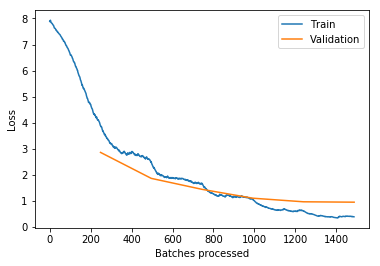

In [55]:
learn.recorder.plot_losses()

### It seems like good results, so save this first iteration of Model Training for future experimenting

In [37]:
learn.save('TC_FirstIteration_6epochs')

In [ ]:
learn.load('TC_FirstIteration_6epochs')

### Unfreezing one layer at a time (especially in text classification) is better than unfreezing everything at once.
### freeze_to(-2)  simply means to unfreeze ONLY the LAST TWO layers for this training iteration.
#### Note:  Here is where we can start to play around with certain hyper-parameters such as LR ranges and momentum

In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-2, 2e-2), moms=(0.7,0.6))

epoch,train_loss,valid_loss,accuracy,time
0,2.806286,2.490214,0.596319,02:33
1,2.172982,1.941217,0.684328,02:30
2,1.372571,1.328269,0.785842,02:40
3,0.729803,1.181941,0.810626,02:45


In [39]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-2, 2e-2), moms=(0.7,0.6))

epoch,train_loss,valid_loss,accuracy,time
0,1.412718,1.640649,0.721405,02:33
1,1.394807,1.266115,0.776389,02:01
2,0.744281,0.887207,0.845046,02:03
3,0.266919,0.782749,0.863717,02:15


### These seem like good results, so let's save the model trained thus far.
#### Note: We could try unfreezing other layers one-by-one prior to unfreezing everything, if we think that might help.

In [40]:
learn.save('TC_SecondIter_4epochs_slice_5eNeg2_2eNeg2_moms0706')

In [ ]:
learn.load('TC_SecondIter_4epochs_slice_5eNeg2_2eNeg2_moms0706')

### Now unfreeze ALL layers and train some more.

In [42]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-2/100, 2e-2), moms=(0.8,0.5))

epoch,train_loss,valid_loss,accuracy,time
0,0.967624,1.279586,0.768597,02:05
1,0.961383,0.904734,0.836666,02:40
2,0.368368,0.653865,0.888268,02:10
3,0.113431,0.609564,0.896207,02:06


### These look like pretty good results (90+ accuracy with seemingly NO Overtraining issues)
### Let's save the final and fully-trained model

In [43]:
learn.save('TC_FinalIter_4epochs_slice_2eNeg2DivBy100_2eNeg2_moms0805')

In [44]:
learn.save_encoder('Final_enc')

### Let's export the fully trained model to be used on other machines (with learn = load_learner()


In [25]:
learn.export('TC_export')

## We can test our Text Classification (TC) Model :

### Below we can Test by running Predict with different texts to see if it classifies correctly.

In [ ]:
pd.options.display.max_colwidth = 0

# Select a Lbl ID (label) to test with
LBL_ID = np.random.choice(np.array(labels_tst),1,False)[0]
    
t = str(df_tst[df_tst['label_id']==LBL_ID].text)

print(LBL_ID, t)

In [34]:
learn.predict(t)

(Category 43295,
 tensor(2484),
 tensor([5.0297e-13, 8.0900e-12, 6.0713e-13,  ..., 8.3214e-14, 5.5184e-12,
         1.3585e-11]))